# An Uncertainty Partition Strategy for Two-stage Stochastic Linear Programming

It is known that two-stage stochastic programming is comulutationally inefficiency due to the sample average approximation (SAA), even for the linear case (2SLP). One way is to apply multi-cut Benders decomposition and further exploit parallel computing, the other would be so-called scenario reduction strategies that aggregate scenarios statistically while trying to preserve the solution quality. Here is a paper about an adaptive partition-basd method (APM) that somehow combines these two ideas, iteratively partitioning the scenarios based on the dual property of the recourse problem. In my opinion, APM is a relatively impractical but mathematically beautiful method. It helps us understand how the uncertain parameters affect the solutions of linear problems. 

> In this notebook, we won't implement APM, but visualize the intuitive math behind it. 

**Reference:** Forcier, Maël, and Vincent Leclere. "Generalized adaptive partition-based method for two-stage stochastic linear programs: geometric oracle and analysis." Operations Research Letters 50.5 (2022): 452-457.

In [3]:
using JuMP, Gurobi, CategoricalArrays, CairoMakie, DataFrames, LinearAlgebra, Distributions, HiGHS, Statistics, Colors

This Prod-mix problem is adapted from section 4.2.3 of the paper. To visualize the uncertainty space in 2-d space, we only consider the uncertainty in the R.H.S (vector h) of the constraints. 

\begin{align*}
\min \quad & -c^\top x + \mathbb{E}[q^\top y] \\
s.t. \quad & T x - y \ge h \\
& x, y \in \mathbb R^2_+
\end{align*}

$$
q=
\begin{bmatrix*}
5\\10
\end{bmatrix*},\quad
c=\begin{bmatrix*}
12\\55
\end{bmatrix*},\quad
T=\begin{bmatrix*}
4 & 10\\
1 & 20
\end{bmatrix*},\quad
h=
\begin{bmatrix*}
\mathcal{U}[5950,6050]\\
\mathcal{U}[3950, 4050]
\end{bmatrix*}
$$

Please refer to this wonderful tutorial if you are interested in normal cone and its importance for LP: https://www.mit.edu/~gfarina/2025/67220s25_L03_more_on_normal_cones/L03.pdf.

#### Parameters

In [4]:
q = [5, 10]
c = [12, 55]
T = [4 10; 1 20]
H1 = Distributions.Uniform(5950, 6050)
H2 = Distributions.Uniform(3950, 4050)

N = 1000
P = fill(1 / N, N)
h1 = (rand(H1, N))
h2 = (rand(H2, N))
h = hcat(h1, h2)
Ω = 1:N

1:1000

#### SAA Model w/ 1000 Samples

In [5]:
function model_build_solve(Ω, h, P)
    model = Model(Gurobi.Optimizer)
    set_silent(model)

    I = 1:2
    @variables(model, begin
            x[i in I]>=0
            y[i in I, ω in Ω] >= 0
        end)

    @constraints(model, begin
        c1[ω in Ω], T[1,1]*x[1] + T[1,2]*x[2] - y[1, ω] <= h[ω,1]
        c2[ω in Ω], T[2,1]*x[1] + T[2,2]*x[2] - y[2, ω] <= h[ω,2]
    end)

    @objective(model, Min, - c[1]*x[1] - c[2]*x[2] + sum(P[ω] * (q[1]*y[1, ω]+q[2]*y[2,ω]) for ω in Ω))

    optimize!(model)

    λ1 = [ dual(c1[ω]) for ω in Ω ]
    λ2 = [ dual(c2[ω]) for ω in Ω ]

    return value.(x), λ1, λ2
end
# assert_is_solved_and_feasible(model)
x_sol, λ1, λ2 = model_build_solve(Ω, h, P)
x_sol

Set parameter Username
Set parameter LicenseID to value 2679099
Academic license - for non-commercial use only - expires 2026-06-18


1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:2
And data, a 2-element Vector{Float64}:
 1148.978987290389
  140.6606707991768

#### Dual Variables

For each scenario we'll have a recouse problem, whose dual form is given by:

$$
Q^D(x,\xi):=\max_{\lambda\in\mathbb R^m}\left\{
(h-Tx)^\top\lambda | W^\top \lambda \le q
\right\}
$$

where the feasible region is
$$
\begin{gather*}
W = \begin{bmatrix}
-1 & 0 \\
0 & -1 \\
\end{bmatrix}, 
\quad q = 
\begin{bmatrix}
5\\
10\\
\end{bmatrix} \\
\lambda_1, \lambda_2 \le 0
\end{gather*}
$$.

For this problem, the realization of uncertainty only affects the cost vector $h-Tx$, while the feasible region $D=\{\lambda\in\mathbb{R}^m: W^\top \lambda \le q\}$ remains identical. To characterize the solution of this type of problems, we can leverage a math concept called **normal cone**. The normal cone of $D$ at $\lambda$ is defined as $N_D(\lambda) = \{\psi\in\mathbb{R}^m: \psi^\top (\lambda' - \lambda), \; \lambda' \in D\}$. And there is a nice optimality condition of LP relevant to normal cone: $\lambda^\star$ solves the dual recourse problem iff the cost vector $(h-Tx) \in N_D(\lambda^\star)$, which is very intuitive geometrically. Please refer to this tutorial if you are interested in normal cone and how it relates to LP: https://people.orie.cornell.edu/dsd95/teaching/orie6300/lec06.pdf. 

Now let's try to visualize this nice property. First we take a look at the dual solutions: 

In [6]:
duals = hcat(λ1, λ2) .* N

cal_labels = [:λ1, :λ2]
# 1) Turn the matrix into a DataFrame
df_duals = DataFrame(duals, cal_labels)
df_duals.h1 = h1
df_duals.h2 = h2

g = groupby(df_duals, cal_labels)
df_duals.label = groupindices(g)

labels = df_duals.label

dual_cost = hcat(h1 .- T[1,:]'*x_sol, h2 .- T[2,:]'*x_sol)
dual_cost_norm = dual_cost ./ sqrt.(sum(abs2, dual_cost; dims=2))

unique_labels = unique(labels)
unique_dual_vals = unique(Vector.(eachrow(duals)))

g_lbl = groupby(df_duals, :label)
stats_lbl = combine(g_lbl,
    nrow => :frequency,
    :λ1 => first => :λ1,
    :λ2 => first => :λ2,
)
stats_lbl.share = stats_lbl.frequency ./ sum(stats_lbl.frequency)
sort!(stats_lbl, :frequency, rev=true)
show(stats_lbl, allrows=true, allcols=true)

6×5 DataFrame
 Row │ label   frequency  λ1        λ2         share   
     │ Int64?  Int64      Float64   Float64    Float64 
─────┼─────────────────────────────────────────────────
   1 │      1        457  -5.0        0.0        0.457
   2 │      2        399   0.0        0.0        0.399
   3 │      4         72   0.0      -10.0        0.072
   4 │      3         70  -5.0      -10.0        0.07
   5 │      5          1  -5.0       -8.57143    0.001
   6 │      6          1  -2.85714    0.0        0.001

There are 6 dual solutions appearing given our 1000 uncertainty realizations, the first four of which are the extreme points of $D$. We visualize $D$ and all the scenarios. Each scenario stands at its associated dual solution and points in the cost vector direction. 

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/zheli/.julia/packages/Makie/aJUtI/src/scenes.jl:259


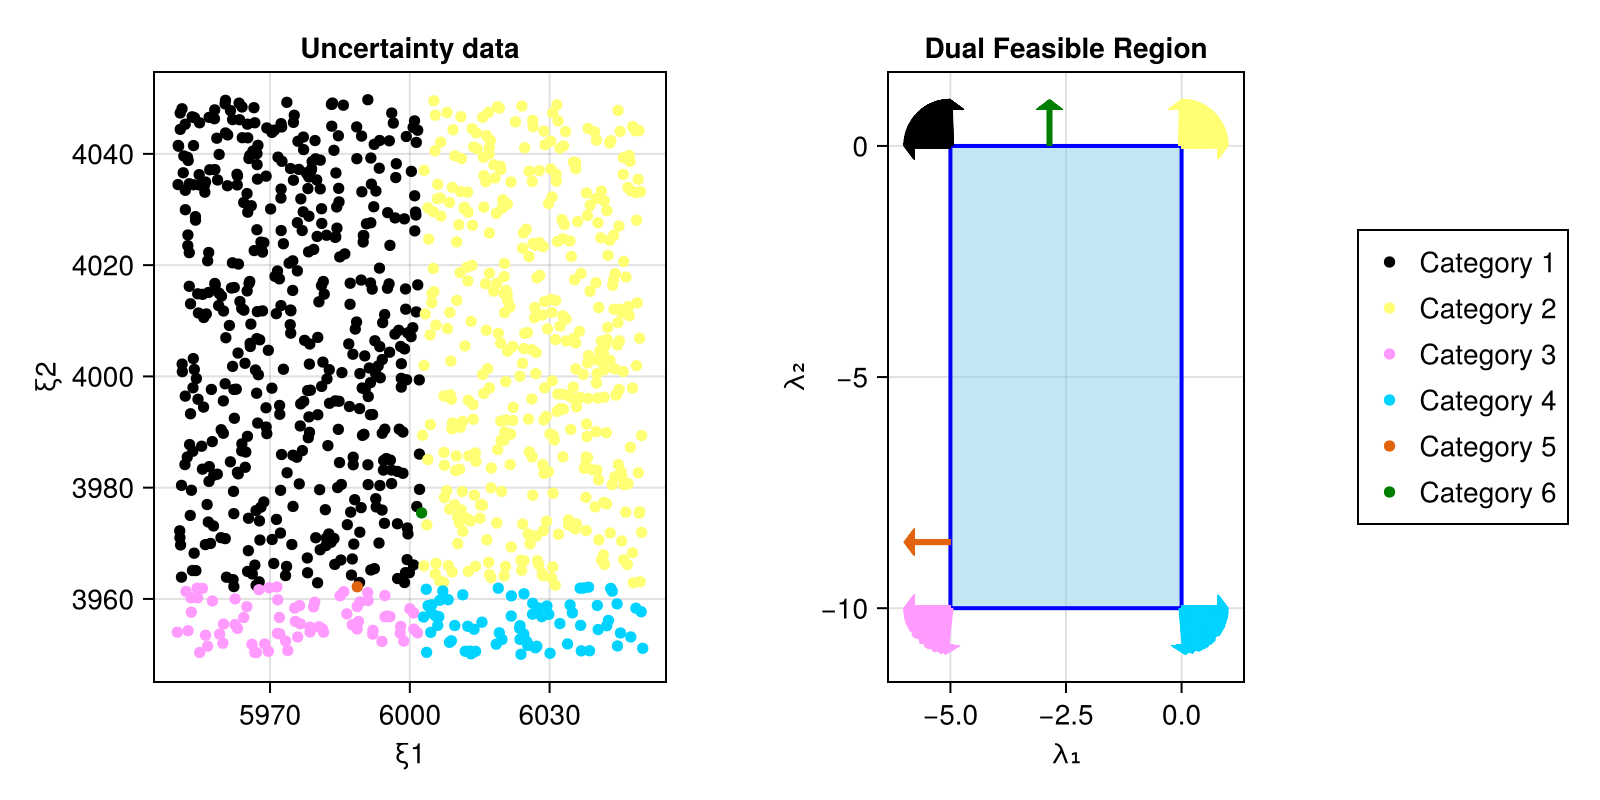

In [7]:
labels = df_duals.label
cats = unique(labels)
palette  = distinguishable_colors(length(cats))

# ── Build figure & axis ──
f  = Figure(resolution = (800, 400))
ax1 = Axis(f[1, 1], xlabel="ξ1", ylabel="ξ2", title="Uncertainty data")

ax2 = Axis(f[1, 2];
    xlabel = "λ₁",
    ylabel = "λ₂",
    title  = "Dual Feasible Region",
    aspect = DataAspect()
)

# ── Pick a distinct color per category ──
cats     = sort(unique(labels))
palette  = distinguishable_colors(length(cats))

# ── Plot one scatter per category, with a `label` for each ──
for i in cats
    mask = labels .== i
    scatter!(
      ax1,
      h1[mask], h2[mask];
      color      = palette[i],
      markersize = 8,
      label      = "Category $(i)",
    )
end


pts = Point2f.([-5,  0,  0, -5],   # x-coordinates
               [-10, -10, 0,  0])  # y-coordinates

# Draw the filled polygon
poly!(ax2, pts;
    color       = (:skyblue, 0.5),
    strokecolor = :blue,
    strokewidth = 2
)

for i in cats
    mask = labels .== i
    arrows2d!(ax2,
        duals[mask, 1], duals[mask, 2],       # tails at λ₁, λ₂ of corner
        dual_cost_norm[mask,1], dual_cost_norm[mask,2];         # Δλ₁, Δλ₂ directions
        tiplength  = 5,
        tipcolor = palette[i],
        shaftcolor = palette[i]
    )
end

Legend(f[1, 3], ax1; title="Category")
# save("../plots/prod_mix_2d.png", f, px_per_unit = 8.0)

f

We see that the cost vector of each scenario lies exactly in the normal cone corresponding to the optimal dual solution. Based on this, we can aggregate scenarios sharing the same dual solutions as a single scenario, in which case we'll only have 6 scenarios in our model. These 6 scenarios are called a *coursest partition* of the original scenario set. Theoretically, this much simpler model yields exactly the same first-stage solution as that obtained by the model with 1000 scenarios. Please refer to the paper if you are interested in the proof. 

In [16]:
mask(i) = df_duals.label .== i
n_agg = maximum(labels)
h_agg = zeros(n_agg, 2)
Ω_agg = 1:n_agg
P_agg = zeros(n_agg)

for i in Ω_agg
    df_cat = df_duals[mask(i), :]
    center = [mean(df_cat.h1), mean(df_cat.h2)]
    weight = size(df_cat)[1] / N

    h_agg[i,:] = center
    P_agg[i] = weight
end

x_sol_agg, λ1_agg, λ2_agg = model_build_solve(Ω_agg, h_agg, P_agg)

println()
println("x = ", [x_sol_agg[1], x_sol_agg[2]])
println("Is the aggregated model yields the same solution? ", x_sol_agg == x_sol)

Set parameter Username
Set parameter LicenseID to value 2679099
Academic license - for non-commercial use only - expires 2026-06-18

x = [1148.978987290389, 140.6606707991768]
Is the aggregated model yields the same solution? true


Recall that to calculate the cost vectors and partition the scenario set accordingly, we need the optimal first-stage solution in the first place, which seems ridiculous. However, APM starts with an arbitraty solution, and refines the partition iteratively until the optimal solution is found. The overall algorithm would not be more efficient than BD, but I think it is inspiring to understand **how scenarios are aggregated based on the (dual) recourse solution**. 

Traditional scenario reduction pays attention to the the uncertain parameter values and aggregate them based on geometrical distances in order to cut off the computational burden. Another concept called [**decision-focused scenario reduction*](https://www.youtube.com/watch?v=HFKrD6n3sXQ&t=2885s) clustering scenarios based on the optimal recourse decision obtained by the uncertainty realization, proposed as a post-processing step that interprets the optimal solution. Now we see a new perspective: **decision-focused (or recourse-based) scenario reduction can also be utilized to enhance computational efficiency**. 